### ESTUDIO DE DISEÑO TECNICO DE PRE INVERSION DEL PROYECTO “CONSTRUCCIÓN PRESA Y SISTEMA DE RIEGO TECNIFICADO EL MOLINO – CAMARGO)”
### Modelación hidraúlica y sedimentología de la cuenca El Molino
#### _Analista: Ing. MSc. Luis Alberto Avila Borja_
##### _Especialista en Recursos Hídricos, Postgrado en Ingeniería y Diseño de presas_

In [3]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [4]:
from landlab.components import DepthSlopeProductErosion
# print(DepthSlopeProductErosion.__doc__)
# print(DepthSlopeProductErosion.__init__.__doc__)

In [5]:
import plotly.graph_objects as go
import numpy as np

def create_interactive_grid_plot(grid, data, title="Interactive Grid", colorbar_title="Value"):
    """
    Convert a Landlab grid visualization to an interactive Plotly plot
    
    Parameters:
    -----------
    grid : Landlab RasterModelGrid
        Your landlab grid object
    data : numpy array
        The data field you want to visualize
    title : str
        Plot title
    colorbar_title : str
        Label for the colorbar
    """
    # Get grid dimensions
    nrows = grid.number_of_node_rows
    ncols = grid.number_of_node_columns
    
    # Reshape data to 2D array
    z_data = data.reshape((nrows, ncols))
    
    # Mask closed boundaries (set to NaN so they appear white/transparent)
    closed_nodes = grid.status_at_node == grid.BC_NODE_IS_CLOSED
    closed_mask = closed_nodes.reshape((nrows, ncols))
    z_data_masked = np.where(closed_mask, np.nan, z_data)
    
    # Create interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=z_data_masked,
        colorscale='Earth',  # You can change this to 'Reds', 'Earth', 'cividis', etc.
        colorbar=dict(title=colorbar_title),
        hovertemplate='Fila: %{y}<br>Columna: %{x}<br>Valor: %{z:.8f}<extra></extra>',
        zsmooth='best'  # Smooth interpolation
    ))
    
    fig.update_layout(
        title=title,
        xaxis_title="X",
        yaxis_title="Y",
        width=800,
        height=600,
        hovermode='closest'
    )
    
    return fig


In [6]:
def create_interactive_grid_with_coords(grid, data, title="Interactive Grid", colorbar_title="Value"):
    """
    Create an interactive plot with actual X,Y coordinates from the grid
    """
    nrows = grid.number_of_node_rows
    ncols = grid.number_of_node_columns
    
    # Get the actual X and Y coordinates
    x_coords = grid.x_of_node.reshape((nrows, ncols))[0, :]  # X values (columns)
    y_coords = grid.y_of_node.reshape((nrows, ncols))[:, 0]  # Y values (rows)
    
    # Reshape and mask data
    z_data = data.reshape((nrows, ncols))
    closed_nodes = grid.status_at_node == grid.BC_NODE_IS_CLOSED
    closed_mask = closed_nodes.reshape((nrows, ncols))
    z_data_masked = np.where(closed_mask, np.nan, z_data)
    
    fig = go.Figure(data=go.Heatmap(
        x=x_coords,
        y=y_coords,
        z=z_data_masked,
        colorscale='Viridis',
        colorbar=dict(title=colorbar_title),
        hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Valor: %{z:.4f}<extra></extra>'
    ))
    
    fig.update_layout(
        title=title,
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
        width=800,
        height=600
    )
    
    return fig

In [7]:
def create_interactive_grid_with_utm(grid, data, title="Interactive Grid", colorbar_title="Value"):
    """
    Create an interactive plot with actual UTM coordinates
    """
    nrows = grid.number_of_node_rows
    ncols = grid.number_of_node_columns
    
    # Get the lower-left corner coordinates (origin offset)
    x_origin = grid.xy_of_lower_left[0]
    y_origin = grid.xy_of_lower_left[1]
    
    # Get relative coordinates and add back the origin
    x_rel = grid.x_of_node.reshape((nrows, ncols))[0, :]
    y_rel = grid.y_of_node.reshape((nrows, ncols))[:, 0]
    
    x_utm = x_rel + x_origin
    y_utm = y_rel + y_origin
    
    # Reshape and mask data
    z_data = data.reshape((nrows, ncols))
    closed_nodes = grid.status_at_node == grid.BC_NODE_IS_CLOSED
    closed_mask = closed_nodes.reshape((nrows, ncols))
    z_data_masked = np.where(closed_mask, np.nan, z_data)
    
    fig = go.Figure(data=go.Heatmap(
        x=x_utm,
        y=y_utm,
        z=z_data_masked,
        colorscale='Viridis',
        colorbar=dict(title=colorbar_title),
        hovertemplate='X (UTM): %{x:.2f}<br>Y (UTM): %{y:.2f}<br>Valor: %{z:.4f}<extra></extra>'
    ))
    
    fig.update_layout(
        title=title,
        xaxis_title="X (UTM)",
        yaxis_title="Y (UTM)",
        width=800,
        height=600
    )
    
    return fig

In [8]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import imshow_grid
from landlab.components import KinwaveImplicitOverlandFlow
from landlab.grid.mappers import map_link_vector_components_to_node
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
import pandas as pd
from scipy import stats
import xarray as xr
import netCDF4 as nc
#import pandoc

In [9]:
def slope_magnitude_at_node(grid, elev):
    # Cálculo del gradiente de erosión en cada link
    grad_at_link = grid.calc_grad_at_link(elev)

    # Establecer gradiente de erosión cero para celdas inactivas
    # (those attached to a closed-boundaries node at either end,
    # or connecting two boundary nodes of any type)
    grad_at_link[grid.status_at_link != grid.BC_LINK_IS_ACTIVE] = 0.0

    # Mapeo del vector de pendiente en nodos en base a pendientes en links adyacentes
    slp_x, slp_y = map_link_vector_components_to_node(grid, grad_at_link)

    # Aplicamos el teorema de Pitagoras para calcular la magnitud de la pendiente
    slp_mag = (slp_x * slp_x + slp_y * slp_y) ** 0.5

    return slp_mag, slp_x, slp_y

In [10]:
# Parámetros del modelo
n = 0.025  # coeficiente de rugosidad, (s/m^(1/3))
dep_exp = 7.0 / 2.0  # exponente de la profuundidad de flujo
R = 16.5  # Intensidad de la tormenta, mm/hr
k_e = 1.0e-9  # Coeficiente de erodabilidad (m/s)/(kg/ms^2)
tau_c = 9.0  # umbral de inicio de erosión, Pa
Peso_Esp_Apar = 1.32

# Parámetros del modelo
rain_duration = 3600.0  # duración de la tormenta, s
run_time = 5000.0  # Duración de la simulación, s
dt = 20.0  # Paso de tiempo del análisis, s
dem_filename = r"F:\PRESAS\camargo\SIG\dem500_ascii.asc"

# Parámetros derivados
num_steps = int(run_time / dt)

# configurar matrices para almacenamiento de tiempos y caudales
time_since_storm_start = np.arange(0.0, dt * (2 * num_steps + 1), dt)
discharge = np.zeros(2 * num_steps + 1)

C:\Users\PC-LIFE\AppData\Local\Temp\ipykernel_26996\1898923371.py:4: DeprecationWarning:

landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead



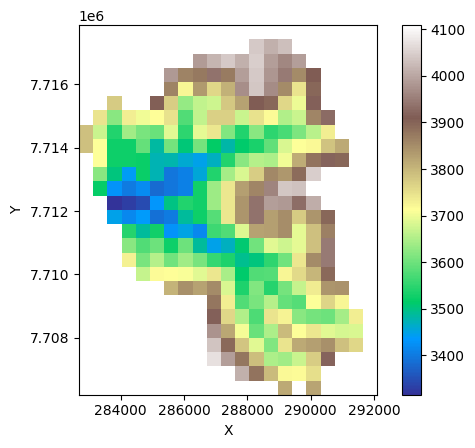

In [27]:
#| label: fig-topo
#| fig-cap: "topografia"
# Lectura del DEM que contenga topografía
(grid, elev) = read_esri_ascii(dem_filename, name="topographic__elevation")
# Configuración de condiicones de frontera y celda de descarga
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED
outlet_nodes = 257
# Graficamos la topografía
imshow_grid(grid, elev, cmap="terrain", color_for_closed='white')

In [12]:
slp_mag, slp_x, slp_y = slope_magnitude_at_node(grid, elev)
#imshow_grid(grid, elev, cmap="terrain", color_for_closed='white')
#plt.quiver(grid.x_of_node, grid.y_of_node, -slp_x, -slp_y)

Mapeamos el raster de pendientes y vectores de pendientes

In [13]:
#imshow_grid(grid, slp_mag, colorbar_label="Slope gradient (m/m)", color_for_closed='white')
#plt.quiver(grid.x_of_node, grid.y_of_node, -slp_x, -slp_y)

Modelación del flujo en un componente de onda cinemática `KinwaveImplicitOverlandFlow` para una intensidad de tormenta I y para una rugosidad n.

In [14]:
olflow = KinwaveImplicitOverlandFlow(grid, runoff_rate=R, roughness=n, depth_exp=dep_exp)

El componente `DepthSlopeProductErosion` requiere el campo magnitud de pendiente `slp_mag` con la denominación `slope_magnitude`.

In [15]:
grid.add_field("slope_magnitude", slp_mag, at="node", clobber=True)
grid

RasterModelGrid((26, 21), xy_spacing=(np.float64(448.56339244924), np.float64(448.56339244924)), xy_of_lower_left=(np.float64(282909.25172346), np.float64(7706429.2976113)))

Se inicia el componente `DepthSlopeProductErosion`.

In [16]:
dspe = DepthSlopeProductErosion(grid, k_e=k_e, tau_crit=tau_c, slope="slope_magnitude")
a = np.array(['dspe'])
df_describe = pd.DataFrame(a)
#df_describe.describe()

Efectuamos una copia del raster de elevaciones para posterior comparacion e iniciamos los componentes de flujo y erosión

In [17]:
starting_elev = elev.copy()

for i in range(num_steps):
    olflow.run_one_step(dt)
    dspe.run_one_step(dt)
    slp_mag[:], slp_x, slp_y = slope_magnitude_at_node(grid, elev)


Visualizamos la erosión instantanea al final de la tormenta en m/s:

In [25]:
#| label: fig-tasa_ero
#| fig-cap: "tasa inst erosion"
#imshow_grid(grid, dspe._E, cmap="cividis", colorbar_label="Tasa instantanea de erosión (m/s)", color_for_closed='white')
fig1 = create_interactive_grid_plot(
    grid, 
    dspe._E, 
    title="Tasa instantánea de erosión",
    colorbar_title="Erosión (m/s)"
)
fig1.show()

Asimismo graficamos la erosión acumulada comparando las elevaciones del terreno antes y despues del proceso.

In [19]:
#imshow_grid(grid, starting_elev - elev, cmap="cividis", colorbar_label="Erosión acumulada (m)", color_for_closed='white')
fig2 = create_interactive_grid_plot(
    grid,
    (starting_elev - elev),
    title="Erosión acumulada",
    colorbar_title="Erosión (m)"
)
fig2.show()

In [20]:
#imshow_grid(grid, (starting_elev - elev)*Peso_Esp_Apar*10000, cmap="cividis", colorbar_label="Erosión acumulada (Ton/ha)", color_for_closed='white')
fig3 = create_interactive_grid_plot(
    grid,
    (starting_elev - elev) * Peso_Esp_Apar * 10000,
    title="Erosión acumulada (Ton/ha)",
    colorbar_title="Erosión (Ton/ha)"
)
fig3.show()

In [21]:
erosion=(starting_elev - elev)*Peso_Esp_Apar*10000

In [22]:
erosionmedia = np.mean(erosion)
print(f"erosión media: {np.round(erosionmedia, decimals=2, out=None)}")

erosión media: 0.54


In [23]:
erosion_total=(starting_elev - elev)*Peso_Esp_Apar*448*448
#imshow_grid(grid, erosion_total, cmap="Reds", colorbar_label="Erosión total (Ton/evento)", color_for_closed='white')
fig4 = create_interactive_grid_with_coords(
    grid,
    erosion_total,
    title="Erosión total por evento",
    colorbar_title="Erosión (Ton/evento)"
)
fig4.update_traces(colorscale='Earth')  # Change colorscale to Reds for this one
fig4.show()

In [24]:
erosion_cuenca = np.sum(erosion_total)
print(f"erosión cuenca debida al evento de precipitacion de intensidad I y duracion D (Ton): {np.round(erosion_cuenca, decimals=2, out=None)}")

erosión cuenca debida al evento de precipitacion de intensidad I y duracion D (Ton): 5937.13
